In [1]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu
!pip3 install bayesian-optimization

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import os
import math
import pickle
import time
import sys

import import_ipynb
import VariationalAutoencoderModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Lambda, Reshape, Input, Dense, Dropout, Conv1D, Conv1DTranspose, MaxPooling1D, Flatten, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.losses import mse
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from bayes_opt import BayesianOptimization

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
importing Jupyter notebook from VariationalAutoencoderModel.ipynb
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


2022-10-01 18:39:54.069532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-01 18:39:54.216352: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-01 18:39:54.216373: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-01 18:39:54.241053: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-01 18:39:54.851393: W tensorflow/stream_executor/pla

In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

2022-10-01 18:39:55.496066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-01 18:39:55.525188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-01 18:39:55.525280: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-01 18:39:55.525349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared obj

In [3]:
path = '../botiot/'
all_files = glob.glob(os.path.join(path , '*.csv'))

files_list = []
for file in all_files:
    df = pd.read_csv(file, index_col = None, encoding = 'utf-8', sep = ',', low_memory = False)
    files_list.append(df)

df_traffic = pd.concat(files_list, axis = 0, ignore_index = True)
df_traffic = df_traffic.drop(columns=['pkSeqID', 'stime', 'flgs', 'flgs_number', 'saddr', 'sport', 'daddr', 'dport', 'subcategory'])
df_traffic['proto'] = df_traffic['proto'].map({'tcp': 1, 'arp': 2, 'udp': 3, 'icmp': 4, 'ipv6-icmp': 5})
df_traffic['state'] = df_traffic['state'].map({'REQ': 1, 'RST': 2, 'ACC': 3, 'CON': 4, 'INT': 5, 'URP': 6, 'FIN': 7, 'NRS': 8, 'ECO': 9, 'TST': 10, 'MAS': 11})

In [4]:
# Attacks

df_attack = df_traffic.query('attack == 1')
df_attack = df_attack.drop(columns=['attack'])
df_attack['category'] = df_attack['category'].map({'DDoS': 0, 'DoS': 1, 'Reconnaissance': 2, 'Theft': 3})

df_ddos = df_attack.query('category == 0')
label_ddos = df_ddos.pop('category')

df_dos = df_attack.query('category == 1')
label_dos = df_dos.pop('category')

df_rec = df_attack.query('category == 2')
label_rec = df_rec.pop('category')

df_unknown = df_attack.query('category == 3')
label_unknown = df_unknown.pop('category')

In [5]:
scaler = MinMaxScaler()

df_ddos_norm = scaler.fit_transform(df_ddos)
df_dos_norm = scaler.fit_transform(df_dos)
df_rec_norm = scaler.fit_transform(df_rec)

df_unknown_norm = scaler.fit_transform(df_unknown)

# OpenSet - Classification With Unknown Attack

In [6]:
# Train set

len_ddos_train = int(0.7 * len(df_ddos_norm))
X_ddos_train = df_ddos_norm[:len_ddos_train]

len_dos_train = int(0.7 * len(df_dos_norm))
X_dos_train = df_dos_norm[:len_dos_train]

len_rec_train = int(0.7 * len(df_rec_norm))
X_rec_train = df_rec_norm[:len_rec_train]

np_train = np.concatenate([X_ddos_train, X_dos_train, X_rec_train])
np_label_train = np.concatenate([label_ddos[:len_ddos_train], label_dos[:len_dos_train], label_rec[:len_rec_train]])

df_train = pd.DataFrame(np_train)
df_label_train = pd.DataFrame(np_label_train)

X_train = df_train.to_numpy()
Y_train = df_label_train.to_numpy()

print(len(X_train))

2567575


In [7]:
# Test set

X_ddos_test = df_ddos_norm[len_ddos_train:]
X_dos_test = df_dos_norm[len_dos_train:]
X_rec_test = df_rec_norm[len_rec_train:]
X_unknown_test = df_unknown_norm

np_test = np.concatenate([X_ddos_test, X_dos_test, X_rec_test, X_unknown_test])
np_label_test = np.concatenate([label_ddos[len_ddos_train:], label_dos[len_dos_train:], 
                                 label_rec[len_rec_train:], label_unknown])

df_test = pd.DataFrame(np_test)
df_label_test = pd.DataFrame(np_label_test)

X_test = df_test.to_numpy()
Y_test = df_label_test.to_numpy()

print(len(X_test))

1100470


In [8]:
# Parameters

original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

epochs = 10
learning_rate = 0.0001
batch_size = 50
anomaly_threshold = 0.042

In [9]:
# KL Loss function

def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [10]:
# Encoder

inputs, encoder, z_var, z_mean = VariationalAutoencoderModel.vae_encoder(
    input_shape, 
    intermediate_dim, 
    latent_dim, 
    VariationalAutoencoderModel.sample)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 35)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 17)           612         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 11)           198         ['dense[0][0]']                  
                                                                                                  
 z_var (Dense)                  (None, 11)           198         ['dense[0][0]']                  
                                                                                            

In [11]:
# Decoder

decoder = VariationalAutoencoderModel.vae_decoder(
    intermediate_dim,
    latent_dim,
    original_dim)

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 11)]              0         
                                                                 
 dense_1 (Dense)             (None, 17)                204       
                                                                 
 dense_2 (Dense)             (None, 35)                630       
                                                                 
Total params: 834
Trainable params: 834
Non-trainable params: 0
_________________________________________________________________


In [12]:
# VAE model

outputs = decoder(encoder(inputs))

opt = optimizers.Adam(learning_rate = learning_rate, clipvalue = 0.5)

vae_model = Model(inputs, outputs, name = 'vae_mlp')
vae_model.compile(optimizer = opt, loss = vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 35)]              0         
                                                                 
 encoder (Functional)        (None, 11)                1008      
                                                                 
 decoder (Functional)        (None, 35)                834       
                                                                 
Total params: 1,842
Trainable params: 1,842
Non-trainable params: 0
_________________________________________________________________


## Train

In [13]:
train_start = time.time()

results = vae_model.fit(X_train, X_train,
                        shuffle = True,
                        epochs = epochs,
                        batch_size = batch_size)

train_end = time.time()
train_time = train_end - train_start
print("Training time:", train_time)

Train on 2567575 samples
Epoch 1/10


2022-10-01 18:40:23.334502: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-01 18:40:23.362695: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


2567575/2567575 [==============================] - 117s 46us/sample - loss: 21.1995
Epoch 2/10
2567575/2567575 [==============================] - 131s 51us/sample - loss: 11.5258
Epoch 3/10
2567575/2567575 [==============================] - 130s 51us/sample - loss: 11.1351
Epoch 4/10
2567575/2567575 [==============================] - 131s 51us/sample - loss: 10.9746
Epoch 5/10
2567575/2567575 [==============================] - 130s 51us/sample - loss: 10.9059
Epoch 6/10
2567575/2567575 [==============================] - 131s 51us/sample - loss: 10.6506
Epoch 7/10
2567575/2567575 [==============================] - 130s 51us/sample - loss: 10.4882
Epoch 8/10
2567575/2567575 [==============================] - 131s 51us/sample - loss: 10.4415
Epoch 9/10
2567575/2567575 [==============================] - 130s 51us/sample - loss: 10.4954
Epoch 10/10
2567575/2567575 [==============================] - 131s 51us/sample - loss: 10.6028
Training time: 1293.6708076000214


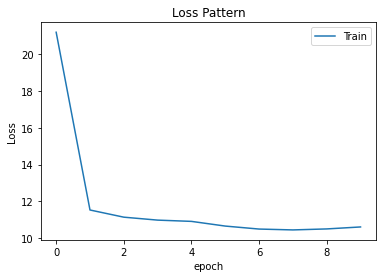

In [14]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## Test

In [15]:
X_train_pred = vae_model.predict(X_train)
error_vector = VariationalAutoencoderModel.get_error_term(X_train, X_train, _rmse = False)
error_thresh = anomaly_threshold

/home/andressa.amaral/.local/lib/python3.7/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
